In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import json
import pandas as pd
from scipy import stats, integrate
from scipy.optimize import least_squares

In [2]:
params = {'font.size': 16,
          'axes.labelsize': 'large'}

plt.rcParams.update(**params)

In [3]:
def velocity(df):
    '''Robust fit to parabolic flow'''
    def residuals(p, z, v):
        f = np.poly1d(p)
        return f(z) - v

    p0 = np.ones(3)
    fit = least_squares(residuals, p0, loss='cauchy', args=(df.z_p, df.v_p))
    return np.poly1d(fit.x)

In [4]:
def u_couette(phi):
    return phi/2. - np.sin(2.*phi)/4.

def f_couette(phi, Gamma):
    return np.exp(Gamma * u_couette(phi))

def pi_couette(phi, Gamma):
    '''unnormalized probability distribution in Couette flow'''
    try:
        a = np.empty_like(phi)
        b = np.empty_like(phi)
        for n, p in enumerate(phi):
            a[n] = integrate.quad(f_couette, 0., p, args=Gamma)[0]
            b[n] = integrate.quad(f_couette, p, 2.*np.pi, args=Gamma)[0]
    except TypeError:
        a = integrate.quad(f_couette, 0., phi, args=Gamma)[0]
        b = integrate.quad(f_couette, phi, 2.*np.pi, args=Gamma)[0]
    return (f_couette(2.*np.pi, Gamma) * a + b) / f_couette(phi, Gamma)

def z_couette(Gamma):
    '''normalization constant for Couette probability'''
    try:
        b = np.empty_like(Gamma)
        for n, g in enumerate(Gamma):
            b[n] = integrate.quad(pi_couette, 0., np.pi, args=g)[0]
    except TypeError:
        b = integrate.quad(pi_couette, 0., np.pi, args=Gamma)[0]
    return b

def p_couette(phi, Gamma):
    '''orientation probability distribution in Couette flow'''
    return pi_couette(phi, Gamma)/z_couette(Gamma)

def p_poiseuille(phi, Gamma0):
    '''approximate orientation probability distribution in Poiseuille flow'''
    func = lambda gamma: p_couette(phi, gamma)
    return integrate.quad_vec(func, 0, Gamma0)[0]/Gamma0

In [5]:
# Digitized data from
# Zottl, et al., Soft Matter (2019), Fig. 2(d)
def convert_coords(x, y):
    x0 = 146
    y0 = 356
    x1 = 461
    y1 = 20
    dtheta = np.pi/2.
    dp = 2.5
    dx = x1 - x0
    dy = y1 - y0
    xfac = dtheta/dx
    yfac = dp/dy
    
    theta = np.pi/2. - xfac * (x - x0)
    p = yfac * (y - y0)
    return (theta, p)

x = np.array([184, 204, 224, 244, 263, 283, 303, 323, 342, 362, 382, 402, 422, 441, 461])
y = np.array([356, 355, 355, 352, 348, 338, 325, 275, 250, 181, 170, 219, 269, 331,   2])
theta_z, p_z = convert_coords(x, y)

In [6]:
def add_dimer(fig, ax, x0, y0, theta=0., rad=0.15):
    theta *= np.pi/180.
    cx = rad * np.cos(theta)
    cy = rad * np.sin(theta)
    trans = (fig.dpi_scale_trans +
             transforms.ScaledTranslation(x0, y0, ax.transData))
    style = dict(radius=rad, facecolor='darkorange', edgecolor='k', zorder=40, transform=trans)
    c1 = patches.Circle((-cx, -cy), **style)
    c2 = patches.Circle((cx, cy), **style)
    ax.add_artist(c1)
    ax.add_artist(c2)

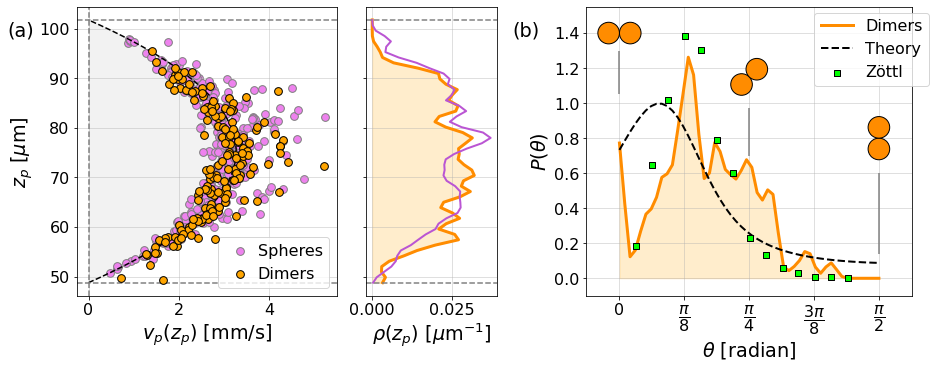

In [8]:
exp = pd.read_csv('data/cheong_separated02.csv')
exp = exp.rename(columns = {'v [μm / s]': "v_p"}) 
exp.v_p /= 1000.
monomer = exp[exp.label=='monomer']
dimer = exp[exp.label=='dimer']

vfit = velocity(monomer)
zwall = sorted(vfit.roots)
zfit = np.linspace(*zwall)

rho_m = stats.gaussian_kde(monomer.z_p, bw_method=0.1)(zfit)
rho_d = stats.gaussian_kde(dimer.z_p, bw_method=0.1)(zfit)

gs_kw = {'width_ratios': [2,1,2.5]}
fig, axes = plt.subplots(1, 3, figsize=(13,5), constrained_layout=True, gridspec_kw=gs_kw)
axa, axb, axc = axes
axa.plot(vfit(zfit), zfit, color='k', linestyle='--')
axa.fill_betweenx(zfit, vfit(zfit), color='gray', alpha=0.1)
axa.scatter(monomer.v_p, monomer.z_p, s=60, ec='gray', color='violet', label='Spheres')
axa.scatter(dimer.v_p, dimer.z_p, s=60, ec='k', color='orange', label='Dimers', zorder=20)

axa.axvline(0, color='gray', linestyle='--')

axa.legend(loc='lower right', handletextpad=0.1)

axa.set_xlabel(r'$v_p(z_p)$ [mm/s]')
axa.set_ylabel(r'$z_p$ [$\mu$m]')

axb.plot(rho_d, zfit, linewidth=3, color='darkorange')
axb.fill_betweenx(zfit, rho_d, color='orange', alpha=0.2)
axb.plot(rho_m, zfit, linewidth=2, color='mediumorchid')
axb.set_xlabel(r'$\rho(z_p)$ [$\mu$m$^{-1}$]')

axa.get_shared_y_axes().join(axa, axb)
axb.set_yticklabels([])

for ax in (axa, axb):
    for z in zwall:
        ax.axhline(z, color='gray', linestyle='--')
    ax.grid(alpha=0.5)
    
#####

jeff = pd.read_json('data/angle_density.json')
Gamma0 = 50
rho = p_poiseuille(jeff.theta, Gamma0)

axc.plot(jeff.theta, jeff.rho_exp * 2./np.pi, linewidth=3, label='Dimers', c='darkorange')
axc.fill_between(jeff.theta, jeff.rho_exp * 2./np.pi, color='orange', alpha=0.2)
axc.plot(jeff.theta, rho, linewidth=2, linestyle='--', label='Theory', c='k')
axc.scatter(theta_z, p_z, marker='s', ec='k', color='lime', label='Zöttl', zorder=10)

axc.set_xticks([0, np.pi/8, np.pi/4, np.pi/8*3, np.pi/2])
axc.set_xticklabels(['0', r'$\dfrac{\pi}{8}$',  r'$\dfrac{\pi}{4}$',  r'$\dfrac{3\pi}{8}$', r'$\dfrac{\pi}{2}$'])
axc.set_xlabel(r'$\theta$ [radian]')
axc.set_ylabel(r'$P(\theta)$')
axc.grid(alpha=0.5)
axc.set_xlim(-0.2, np.pi/2.+0.2)
axc.set_ylim(-0.1, 1.55)

axc.legend(bbox_to_anchor=(0.7, 0.98), loc='upper left', borderaxespad=0.)

add_dimer(fig, axc, 0, 1.4)
add_dimer(fig, axc, np.pi/4., 1.15, 45.)
add_dimer(fig, axc, np.pi/2., 0.8, 90.)
axc.vlines([0, np.pi/4., np.pi/2.], [1.05, 0.7, 0.14], [1.3, 0.97, 0.6], color='gray')

axa.text(0.01, 0.91, '(a)', transform=fig.transFigure, fontsize='large')
axc.text(0.55, 0.91, '(b)', transform=fig.transFigure, fontsize='large')

fig.savefig('jeffery04.pdf', facecolor='w', dpi=150)

## Rotational diffusion coefficient for a spheroid
M. Hoffmann, C. S. Wagner, L. Harnau and A. Wittemann,
Brownian diffusion of submicron-sized particle clusters,
ACS Nano 3, 3326 (2009)

In [9]:
import scipy.constants as c

def Gfac(p):
    if p < 1:
        fac = np.log((1. + np.sqrt(1. - p**2))/p) / np.sqrt(1. - p**2)
    else:
        fac = np.arctan(np.sqrt(p**2 - 1.))/np.sqrt(p**2 - 1.)
    return fac

def D_r(p, d_p, T=298, eta=1.e-3):
    return 3. * c.Boltzmann * T / (16. * np.pi * eta * d_p**3)

def Dr_par(p, d_p, **kwargs):
    Dr = D_r(p, d_p, **kwargs)
    Dr *= (1. - p**2 * Gfac(p))/(1. - p**2)/p**2
    return Dr
    
def Dr_perp(p, d_p, **kwargs):
    Dr = D_r(p, d_p, **kwargs)
    Dr *= ((2. - p**2) * Gfac(p) - 1.) / (1. - p**4)
    return Dr

In [10]:
print('Dr_perp = {:.2f} s^-1'.format(Dr_perp(0.5, 1.05e-6)))
print('Dr_par  = {:.2f} s^-1'.format(Dr_par(0.5, 1.05e-6)))

Dr_perp = 0.38 s^-1
Dr_par  = 0.70 s^-1


In [11]:
zwall[1]-zwall[0]

52.97162720840705